# CRiCD4 Run1 - QC and exploratory analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import scanpy as sc
import anndata as ad
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

from preprocess import _convert_oak_path
import qc_plots
from sgrna_assignment import sgrna_assignments2adata

In [3]:
import psutil

# Get system memory information
mem_info = psutil.virtual_memory()

# Display total, available, and used memory in GB
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")
print(f"Used memory: {mem_info.used / (1024**3):.2f} GB")
print(f"Memory percentage used: {mem_info.percent}%")

Total memory: 995.52 GB
Available memory: 129.37 GB
Used memory: 858.86 GB
Memory percentage used: 87.0%


In [4]:
PLOTDIR = f'../../results/CD4iR1_Psomagen/'
sc.settings.figdir = PLOTDIR
os.makedirs(PLOTDIR, exist_ok=True)

def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

Configuration

In [5]:
# Read config
experiment_name = 'CD4iR1_Psomagen'
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

config = config[experiment_name]
datadir = _convert_oak_path(config['datadir'])
sample_metadata_csv = _convert_oak_path(config['sample_metadata'])

In [6]:
datadir

'/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/'

## Summary of QC metrics

In [7]:
sample_metadata = pd.read_csv(sample_metadata_csv, index_col=0)
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)

if config['lane_ids'] is not None:
    all_lanes = config['lane_ids']
all_library_ids = sample_metadata['library_id'].tolist()
all_samples = []
for library_id in all_library_ids:
    for lane_id in all_lanes:
        all_samples.append(f"{library_id}.{lane_id}")
len(all_samples)

92

In [9]:
from tqdm.notebook import tqdm
    
all_qc_summary = pd.DataFrame()
all_count_perturbs = pd.DataFrame()
for sample_id in tqdm(all_samples, desc="Processing samples"):
    try:
        qc_summary = pd.read_csv(f'{datadir}/tmp/{sample_id}.qc_summary.csv', index_col=0)
        count_perturbs = pd.read_csv(f'{datadir}/tmp/{sample_id}.perturbation_counts.csv', index_col=0)
        all_qc_summary = pd.concat([all_qc_summary, qc_summary])
        all_count_perturbs = pd.concat([all_count_perturbs, count_perturbs])
    except:
        continue
        
all_count_perturbs = all_count_perturbs.pivot(index='guide_id', columns='sample_id', values='n_cells').fillna(0)

Processing samples:   0%|          | 0/92 [00:00<?, ?it/s]

In [10]:
all_qc_summary.to_csv(f'{datadir}/QC_summary_stats.csv')
all_count_perturbs.to_csv(f'{datadir}/perturbation_counts.csv')

In [11]:
all_qc_summary = pd.read_csv(f'{datadir}/QC_summary_stats.csv', index_col=0)
all_count_perturbs = pd.read_csv(f'{datadir}/perturbation_counts.csv', index_col=0)

In [12]:
all_qc_summary.head()

,library_id,lane_id,mean_total_counts,mean_n_genes,mean_pct_counts_mt,mean_top_guide_UMI_counts,n_cells,n_low_quality_cells,NTC single sgRNA,multi sgRNA,no sgRNA (>= 3 UMIs),targeting single sgRNA,n_unique_guides,n_unique_perturbed_genes,mean_cells_x_guide,mean_cells_x_perturbed_gene
0,CD4i_R1_D1_Rest_CD4i_R1_Ultima,CD4i_R1L01,9698.8660,3755.576292,0.423116,68.068244,137668,165,3385,23412,36381,74325,16009,10137,4.854145,7.665976
0,CD4i_R1_D1_Rest_CD4i_R1_Ultima,CD4i_R1L02,9965.8230,3809.356878,0.426269,70.995294,135716,184,3372,22973,35340,73847,16246,10256,4.753108,7.529154
0,CD4i_R1_D1_Rest_CD4i_R1_Ultima,CD4i_R1L03,10194.8125,3857.370641,0.427786,70.545034,137289,178,3396,23241,35241,75233,16308,10289,4.821499,7.642045
0,CD4i_R1_D1_Rest_CD4i_R1_Ultima,CD4i_R1L04,9898.1960,3800.514213,0.425399,69.329759,138604,170,3426,22914,36616,75478,16253,10300,4.854735,7.660583
0,CD4i_R1_D1_Rest_CD4i_R1_Ultima,CD4i_R1L05,10604.7890,3935.811115,0.431482,71.585551,134129,169,3279,21648,35505,73528,16001,10174,4.800137,7.549341


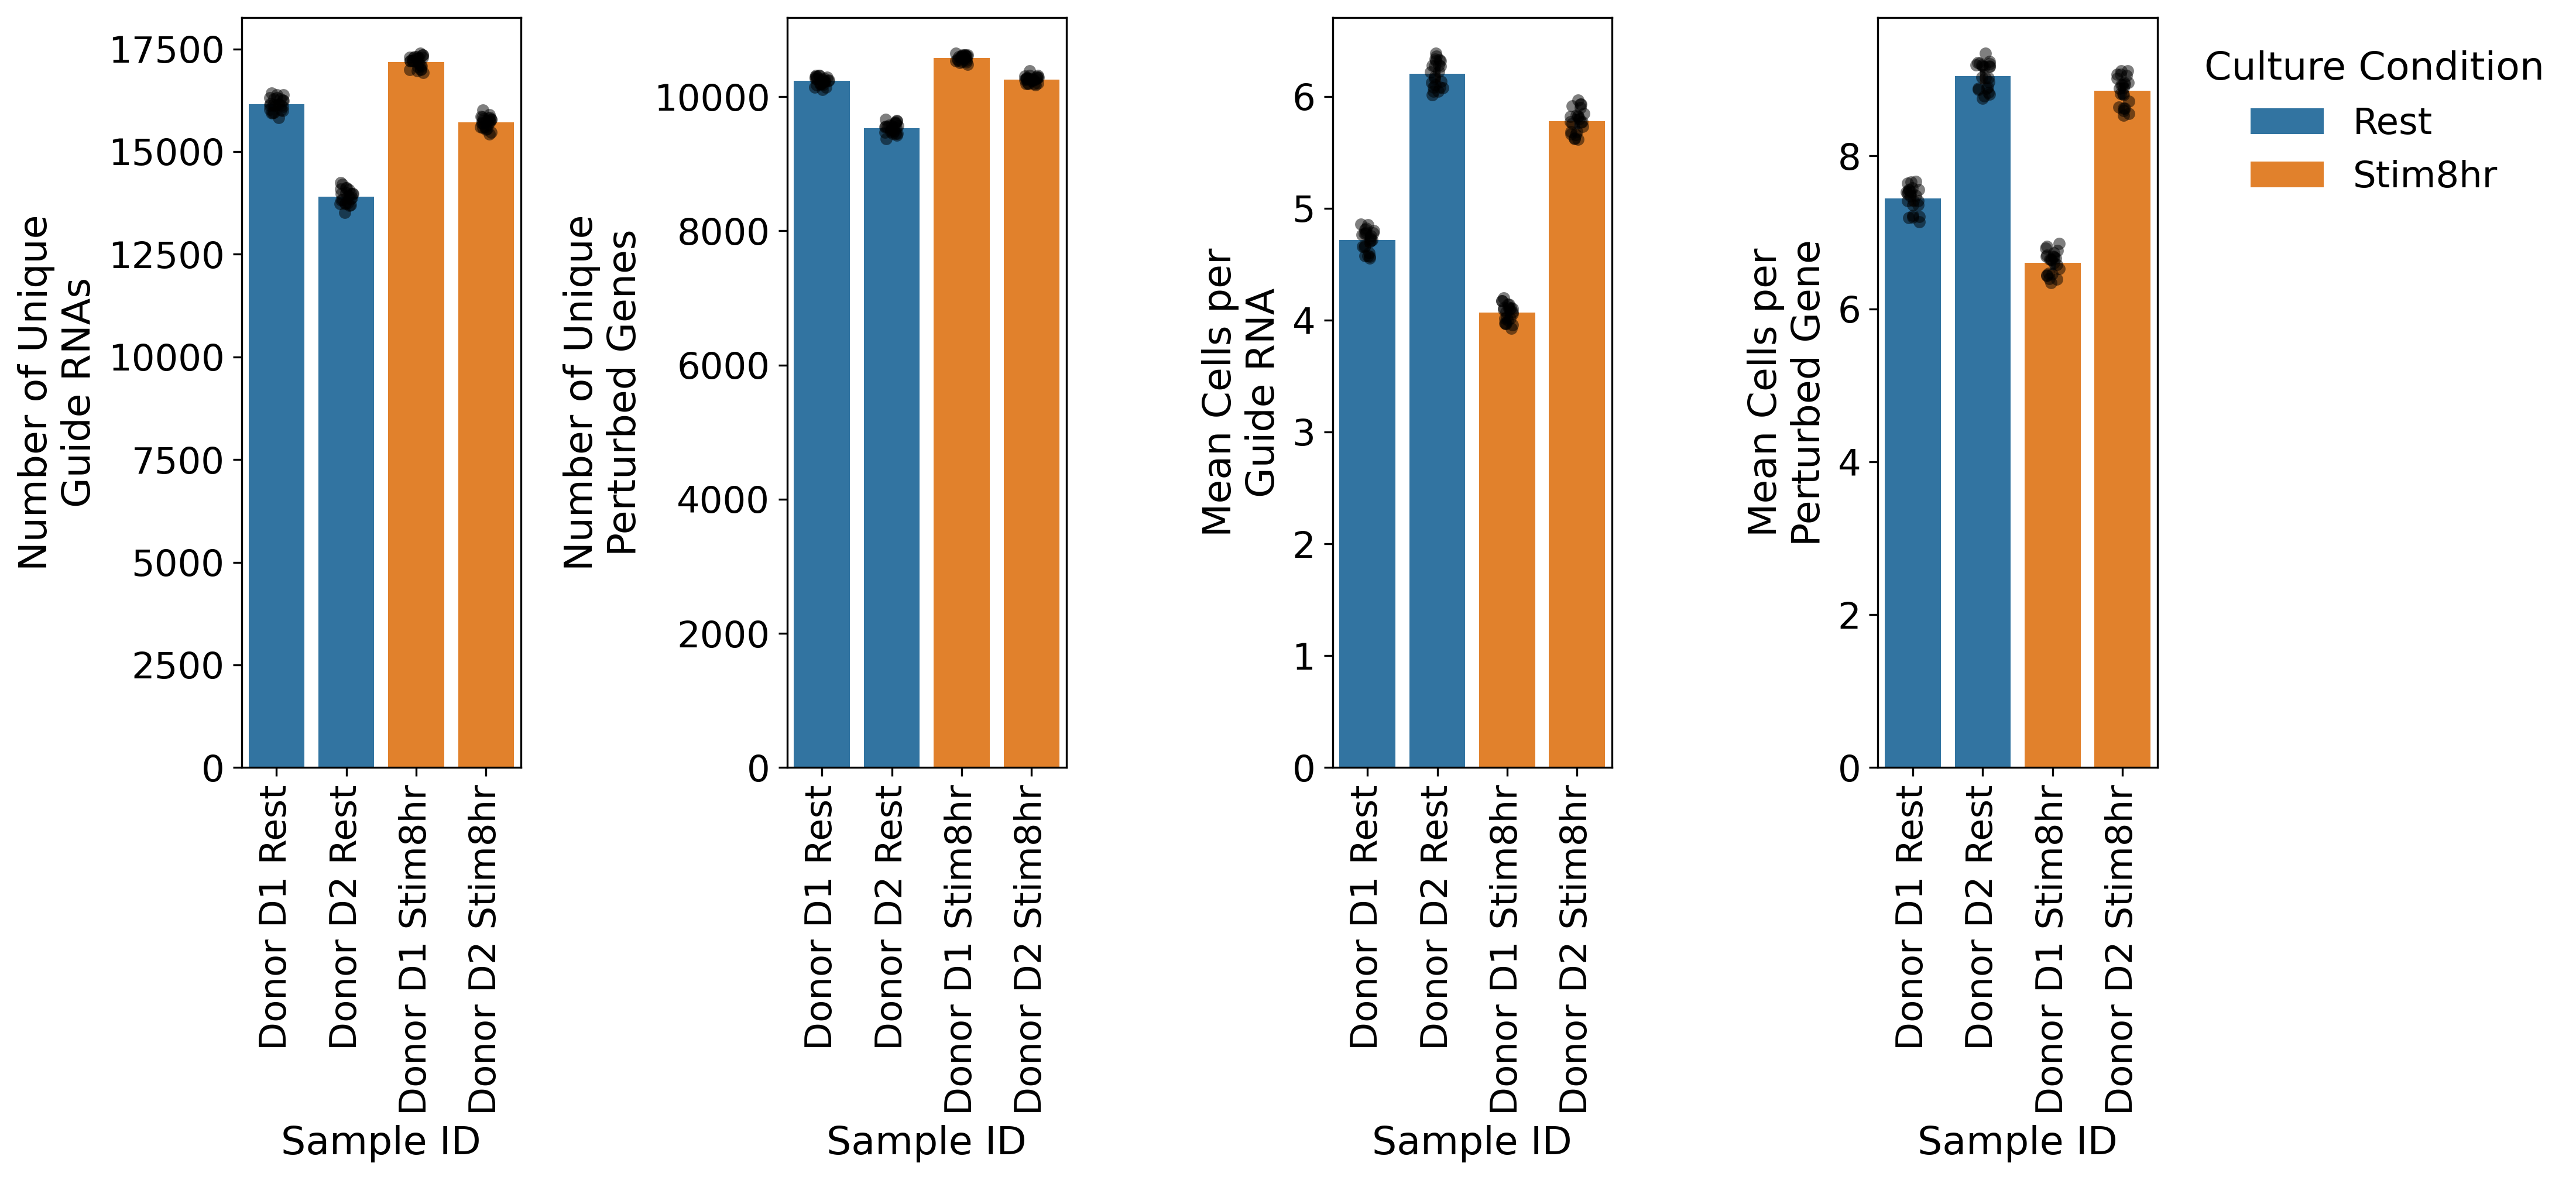

In [13]:
pl_cols = ['n_unique_guides',
       'n_unique_perturbed_genes', 'mean_cells_x_guide',
       'mean_cells_x_perturbed_gene'
       ]

# Define better y-axis labels
y_labels = {
    'n_unique_guides': 'Number of Unique\nGuide RNAs',
    'n_unique_perturbed_genes': 'Number of Unique\nPerturbed Genes',
    'mean_cells_x_guide': 'Mean Cells per\nGuide RNA',
    'mean_cells_x_perturbed_gene': 'Mean Cells per\nPerturbed Gene'
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = 'Donor ' + all_qc_summary['donor_id'] + ' ' + all_qc_summary['culture_condition']

# Create subplots for each metric in one row
n_cols = len(pl_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(15, 7))

for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', ax=axes[idx])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=5, alpha=0.5, 
                 legend=False, ax=axes[idx])
    
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel('Sample ID')
    axes[idx].set_ylabel(y_labels[col])
    
    # Only show legend on first plot
    if idx != 3:
        axes[idx].get_legend().remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

plt.tight_layout()

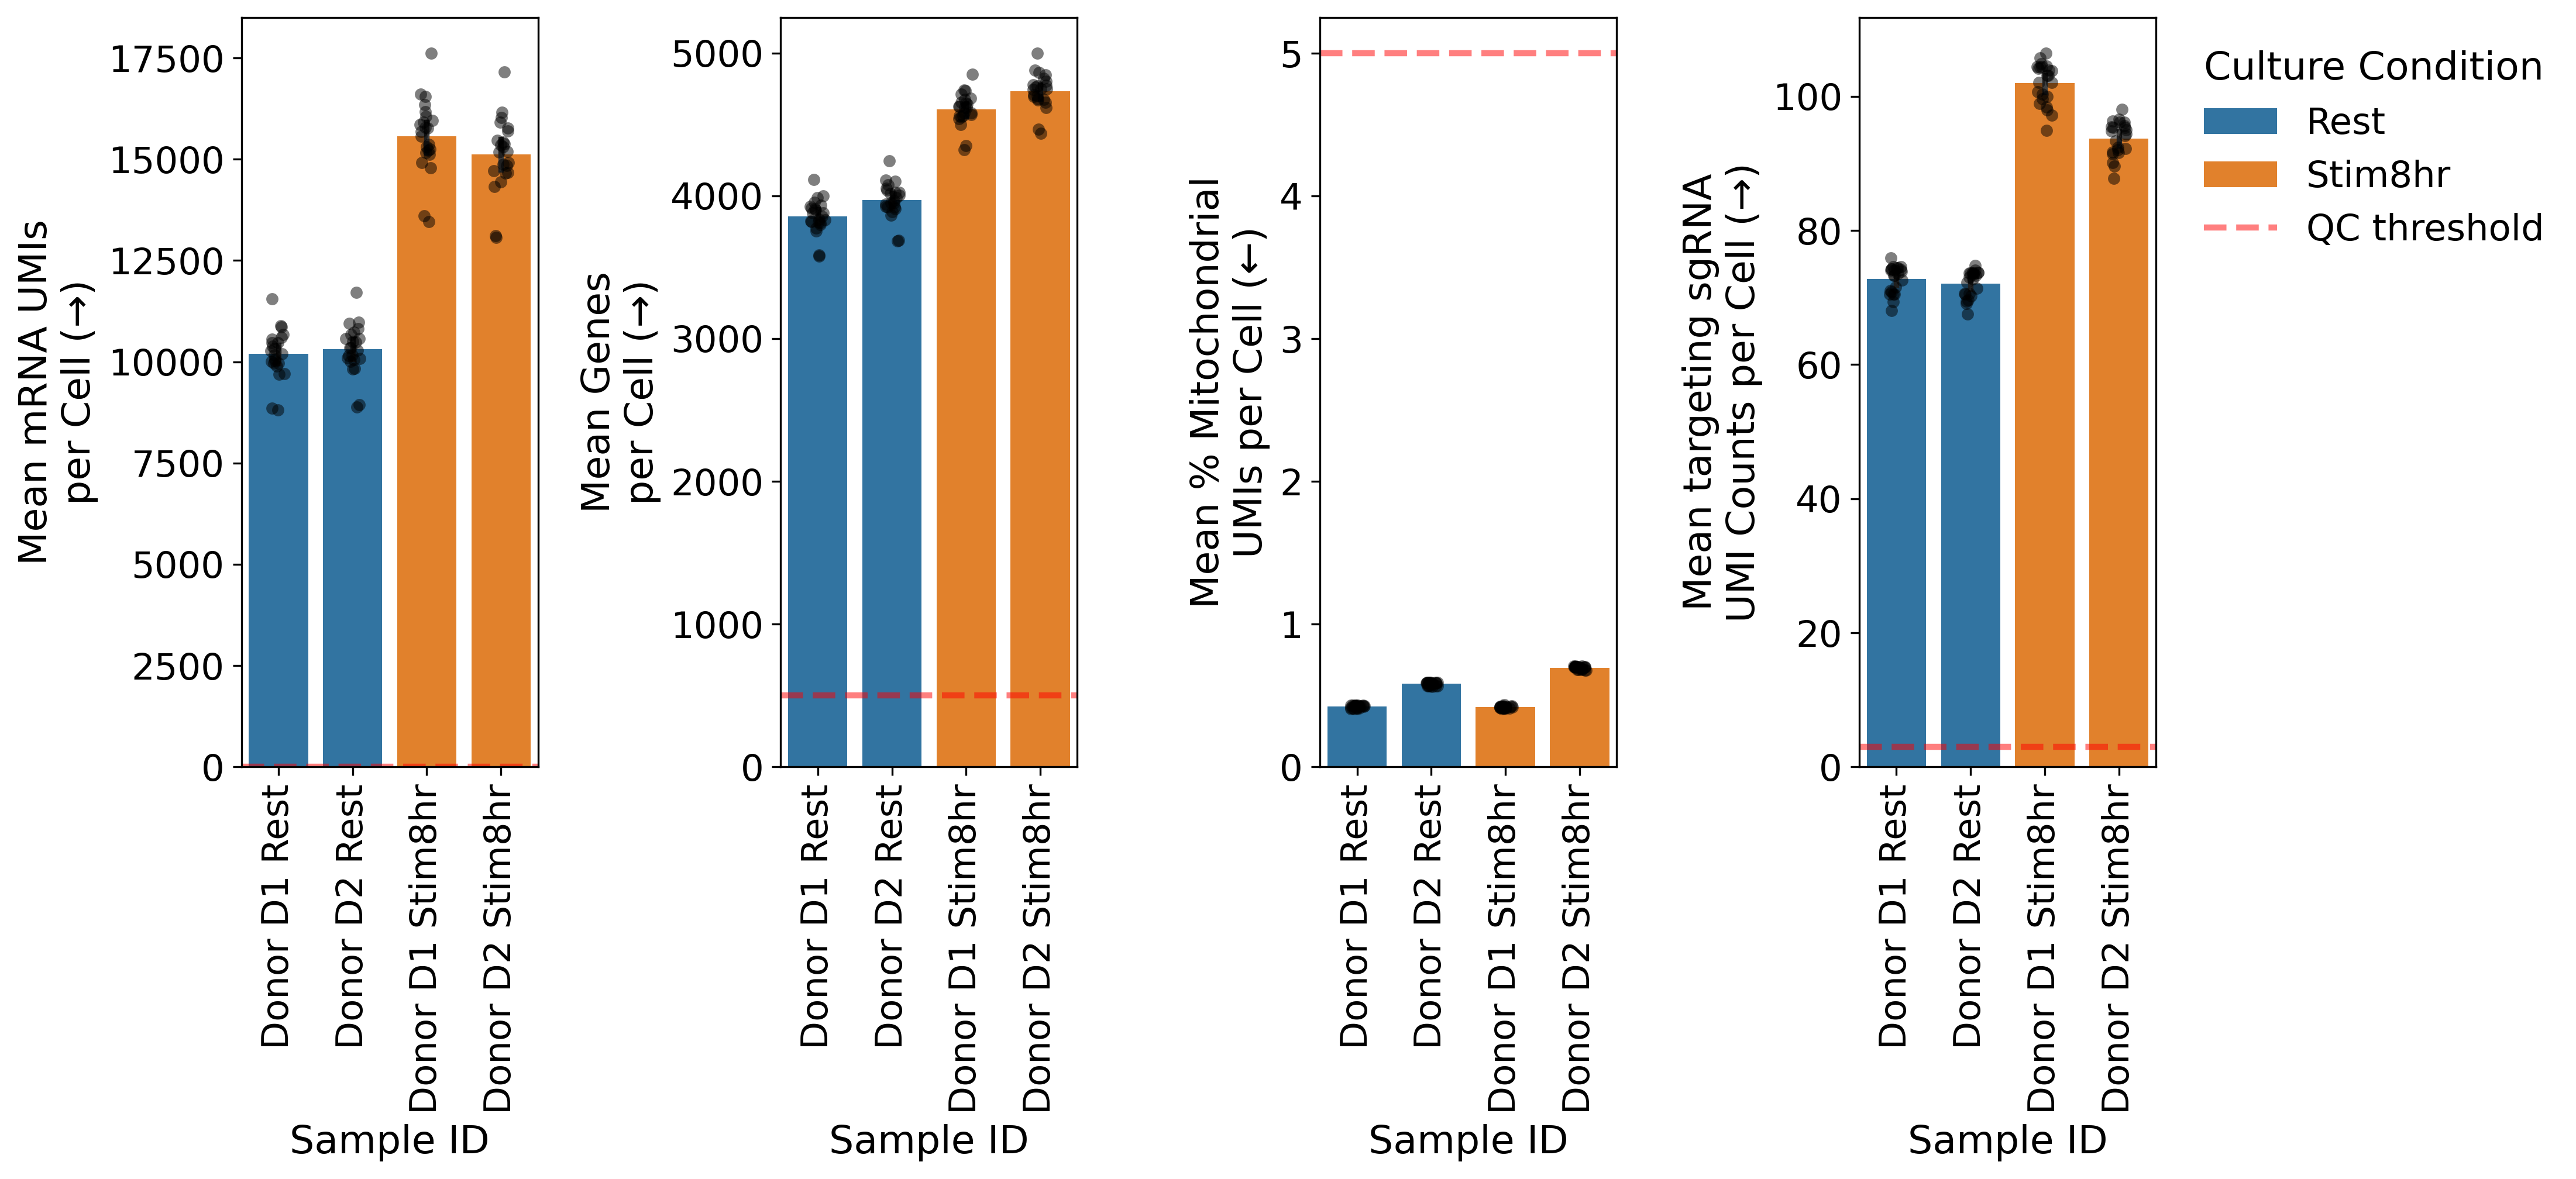

In [14]:
pl_cols = ['mean_total_counts', 'mean_n_genes',
       'mean_pct_counts_mt', 'mean_top_guide_UMI_counts'
       ]

qc_thresholds = {
    'mean_total_counts':0,
    'mean_n_genes':500,
    'mean_pct_counts_mt':5,
    'mean_top_guide_UMI_counts':3   
}

# Define better y-axis labels
y_labels = {
    'mean_total_counts': 'Mean mRNA UMIs\nper Cell (→)',  # Higher is better
    'mean_n_genes': 'Mean Genes\nper Cell (→)',  # Higher is better
    'mean_pct_counts_mt': 'Mean % Mitochondrial\nUMIs per Cell (←)',  # Lower is better
    'mean_top_guide_UMI_counts': 'Mean targeting sgRNA\nUMI Counts per Cell (→)'  # Higher is better
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = 'Donor ' + all_qc_summary['donor_id'] + ' ' + all_qc_summary['culture_condition']

# Create subplots for each metric in one row
n_cols = len(pl_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(15, 7))

for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', ax=axes[idx])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=5, alpha=0.5, 
                 legend=False, ax=axes[idx])
    
    # Add horizontal dotted line for QC threshold
    threshold = qc_thresholds[col]
    axes[idx].axhline(y=threshold, color='red', linestyle='--', alpha=0.5, 
                     label=f'QC threshold', linewidth=2.5)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel('Sample ID')
    axes[idx].set_ylabel(y_labels[col])
    
    # Only show legend on first plot
    if idx != 3:
        axes[idx].get_legend().remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

plt.tight_layout()

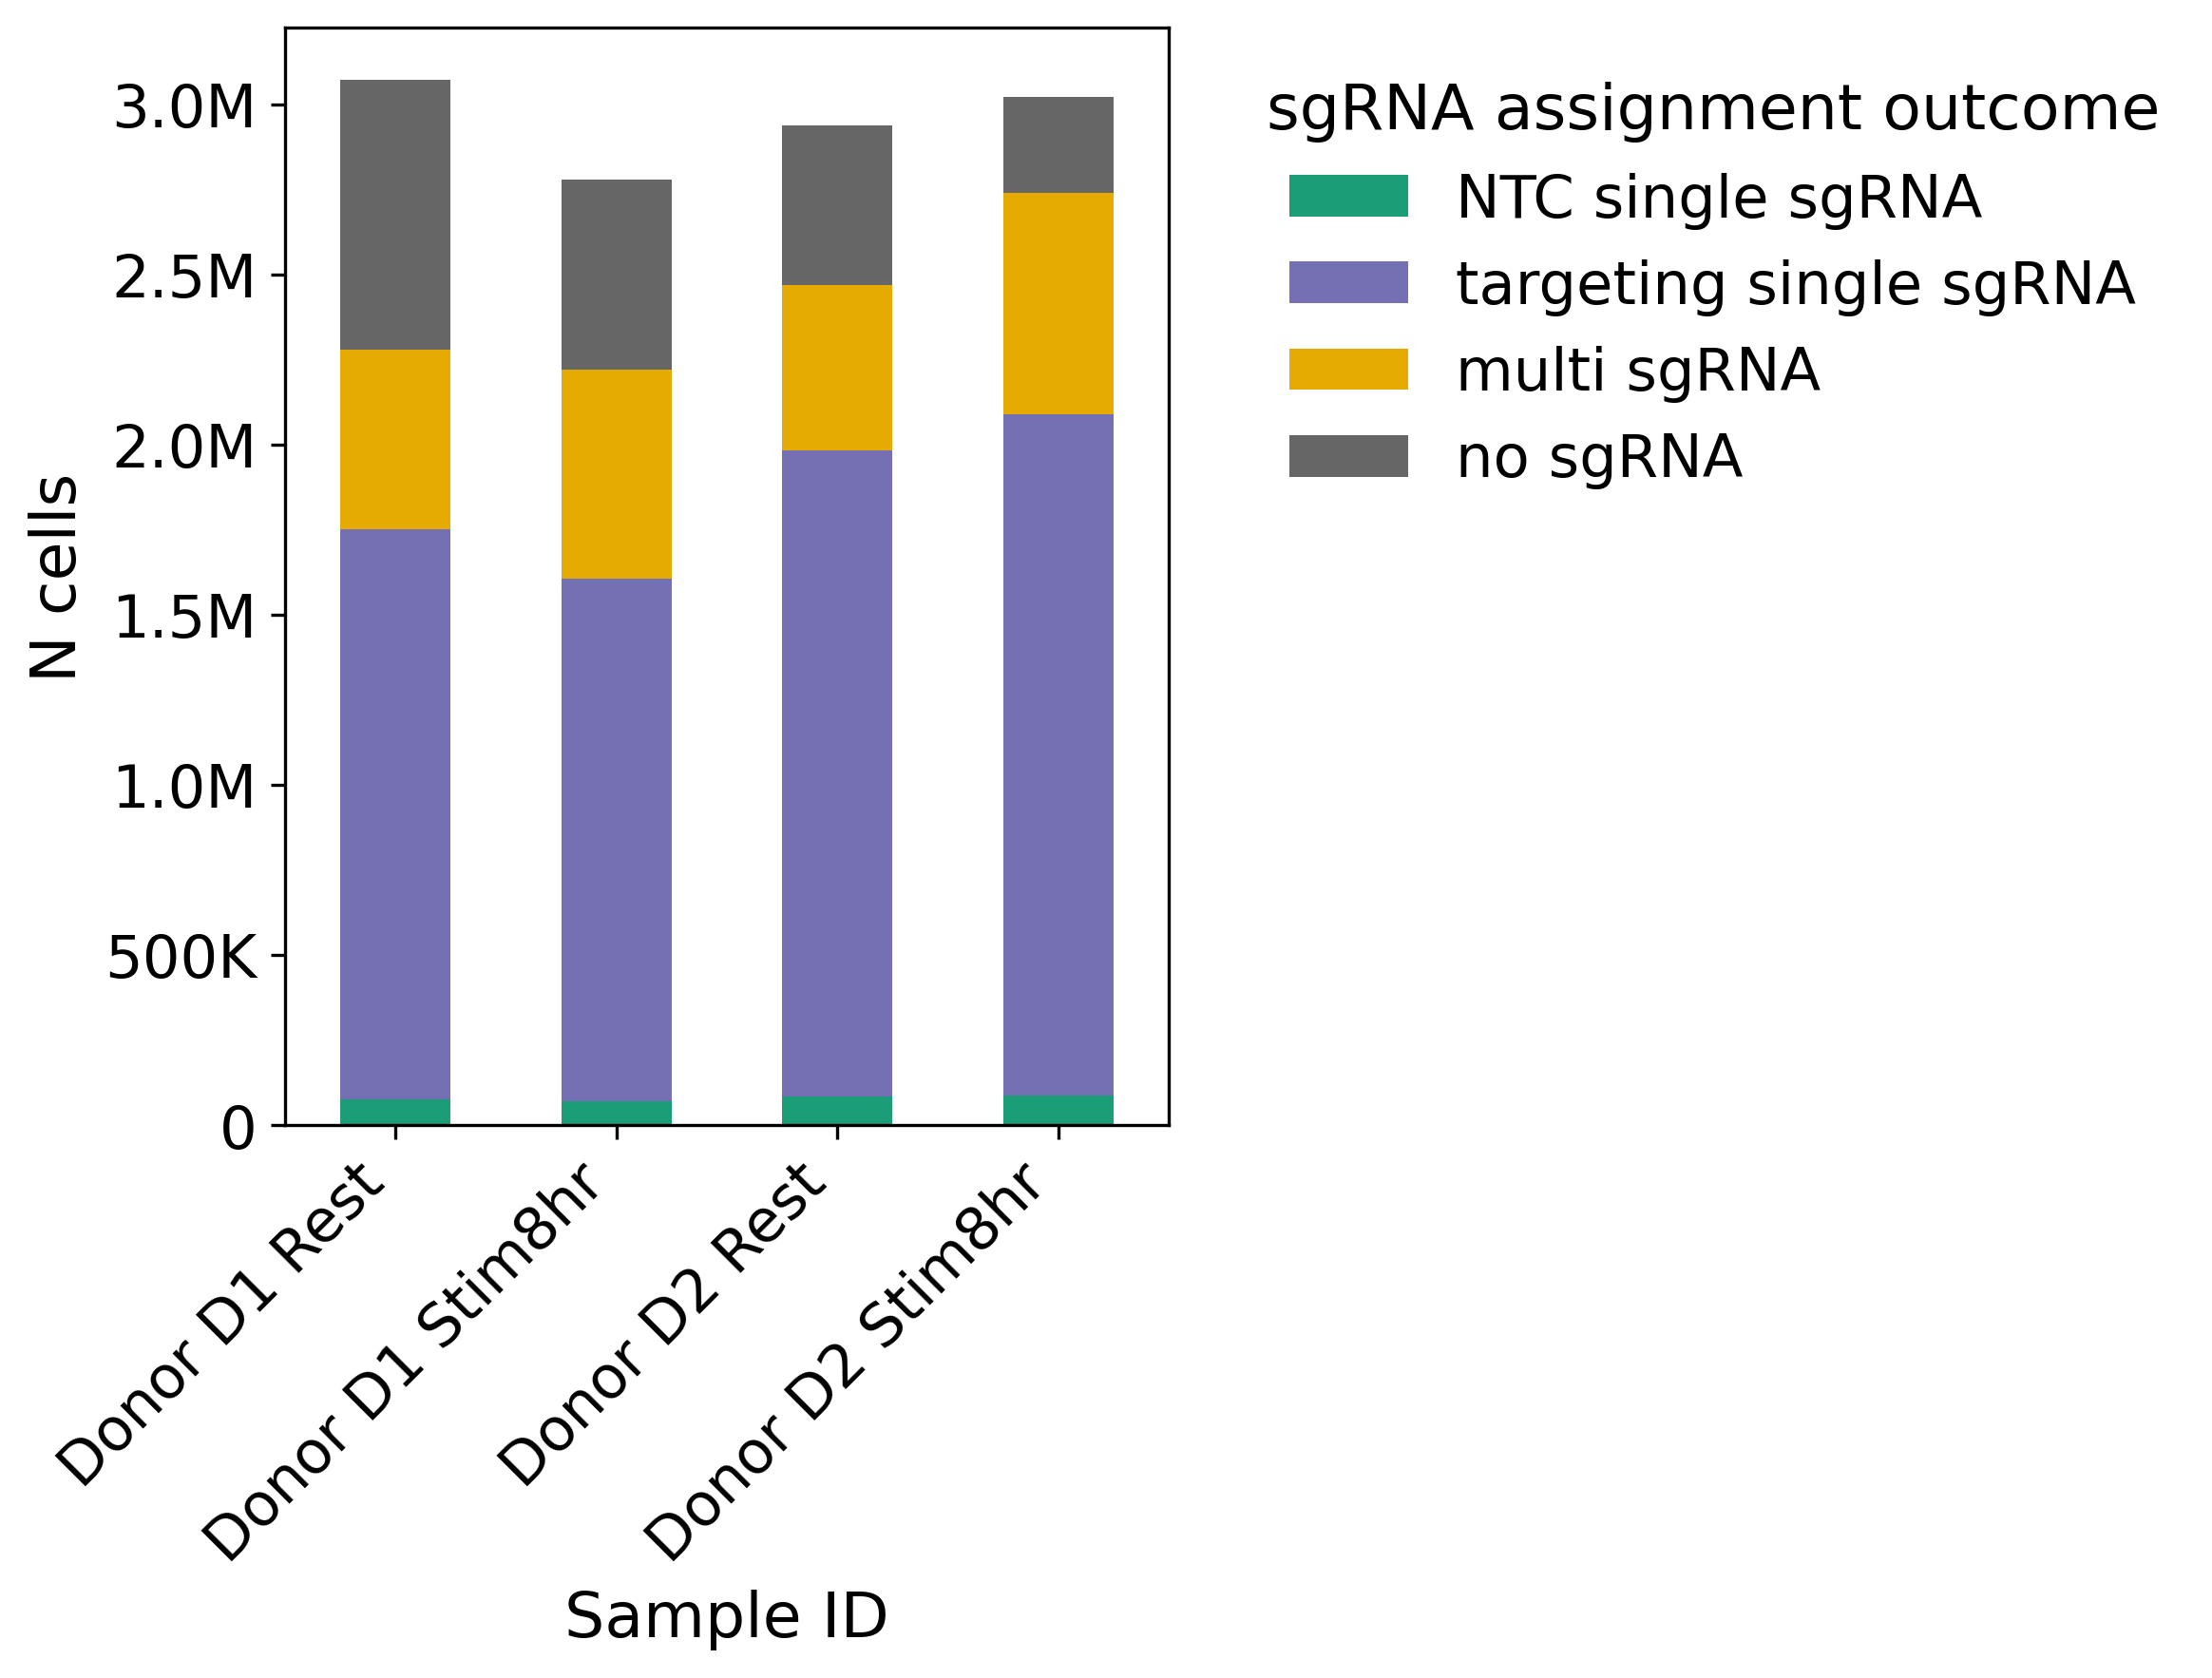

In [15]:
pl_df = all_qc_summary.groupby('sample_id').sum()
# Define the order for the groups
group_order = ['NTC single sgRNA', 'targeting single sgRNA', 'multi sgRNA', 'no sgRNA (>= 3 UMIs)']
group_counts = pl_df[group_order]
group_counts = group_counts.rename({'no sgRNA (>= 3 UMIs)':'no sgRNA'}, axis=1)
# group_fractions = group_counts.div(group_counts.sum(axis=1), axis=0)
ax = group_counts.plot(kind='bar', stacked=True, figsize=(4,5), colormap='Dark2')
plt.xticks(rotation=45, ha='right')
plt.ylabel('N cells')
plt.xlabel('Sample ID')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='sgRNA assignment outcome', frameon=False)
# Format y-axis to use M notation for millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{int(x/1e3)}K' if x >= 1e3 else int(x)))

# ax.ticklabel_format(useOffset=False)
plt.tight_layout()

### Number of cells per perturbation

In [16]:
# Download and read the Core Essential and non-essential gene list (as used in GeneBayes paper)
ceg_url = "https://raw.githubusercontent.com/macarthur-lab/gene_lists/master/lists/CEGv2_subset_universe.tsv"
neg_url = 'https://raw.githubusercontent.com/macarthur-lab/gene_lists/refs/heads/master/lists/NEGv1_subset_universe.tsv'
core_essential = pd.read_csv(ceg_url, sep='\t', header=None)[0].tolist()
core_nonessential = pd.read_csv(neg_url, sep='\t', header=None)[0].tolist()

## Load IL2 hits
schmidt_crispri = pd.read_excel('../../metadata/Schmidt2022_hits_Supplementary_table_2.xlsx', usecols=range(10))
schmidt_crispri_hits = schmidt_crispri[schmidt_crispri['Hit'] & (schmidt_crispri['CRISPRa_or_i'] == 'CRISPRi') & (schmidt_crispri['CD4_or_CD8'] == 'CD4')]

# Create dictionary where key is hit type and values are lists of genes
hit_type_dict = {}
for hit_type in schmidt_crispri_hits['Hit_Type'].unique():
    hit_type_dict[hit_type] = schmidt_crispri_hits[schmidt_crispri_hits['Hit_Type'] == hit_type]['Gene'].tolist()


In [17]:
pl_df = all_count_perturbs.reset_index().melt(id_vars='guide_id', var_name='library_id', value_name='n_cells')
pl_df = pd.merge(
    sgrna_library_metadata[['sgrna_id', 'perturbed_gene_name']].rename({'sgrna_id':'guide_id'}, axis=1),
    pl_df
)
pl_df['sample_id'] = pl_df.library_id.str.split('.').str[0]
pl_df['culture_condition'] = np.where(pl_df['sample_id'].str.contains('Rest'), 'Rest', 'Stim8hr')

n_cells_count_df = pl_df.groupby(['perturbed_gene_name','culture_condition'])['n_cells'].sum().reset_index()


In [18]:
n_cells_count_df.groupby('culture_condition')['n_cells'].mean()

culture_condition
Rest       298.124022
Stim8hr    294.939585
Name: n_cells, dtype: float64

In [19]:
n_cells_count_df['Schmidt_hits'] = np.nan
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Positive Hit']), 'IL2_pos_hit', n_cells_count_df['Schmidt_hits'])
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Negative Hit']), 'IL2_neg_hit', n_cells_count_df['Schmidt_hits'])

n_cells_count_df['essential_genes'] = np.nan
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_essential), 'gold standard essential', n_cells_count_df['essential_genes'])
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_nonessential), 'gold standard non-essential', n_cells_count_df['essential_genes'])


In [20]:
n_cells_count_df.head()

,perturbed_gene_name,culture_condition,n_cells,Schmidt_hits,essential_genes
0,A1BG,Rest,280.0,nan,nan
1,A1BG,Stim8hr,303.0,nan,nan
2,A2M,Rest,148.0,nan,nan
3,A2M,Stim8hr,110.0,nan,nan
4,AAAS,Rest,124.0,nan,nan


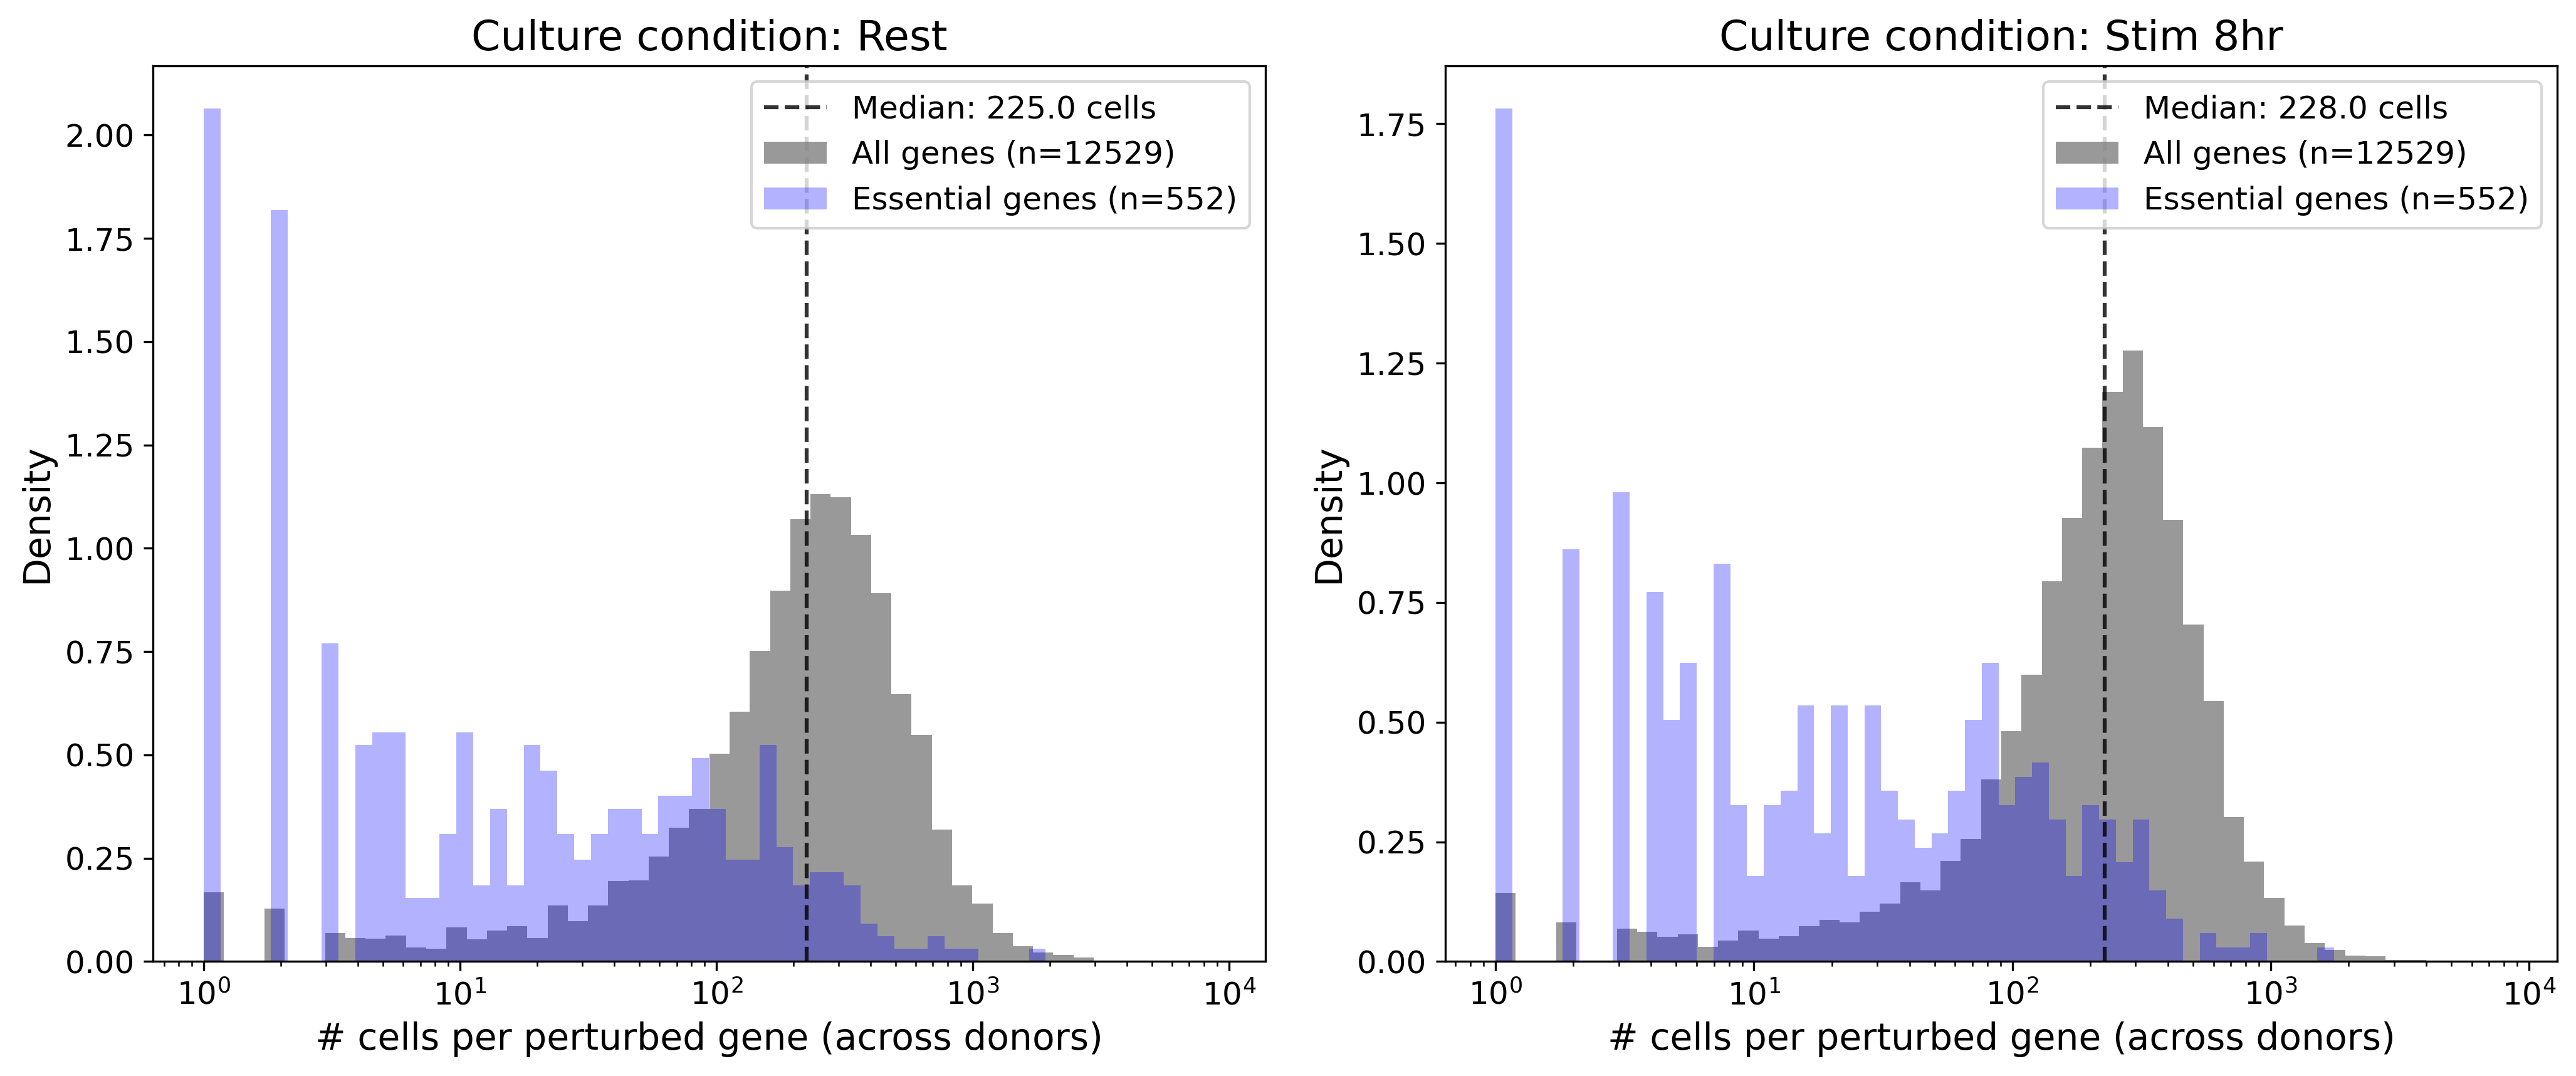

In [21]:
# Create histogram with density lines comparing IL2_neg_hit genes and essential genes with all genes
# neg_hits_df = n_cells_count_df[(n_cells_count_df['Schmidt_hits'] == 'IL2_neg_hit') ]
essential_df = n_cells_count_df[n_cells_count_df['essential_genes'] == 'gold standard essential']
all_genes_df = n_cells_count_df[n_cells_count_df.perturbed_gene_name != 'NTC']  # All genes except NTC

# Create figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Rest condition
rest_all = all_genes_df[all_genes_df['culture_condition'] == 'Rest']
# rest_neg = neg_hits_df[neg_hits_df['culture_condition'] == 'Rest']
rest_essential = essential_df[essential_df['culture_condition'] == 'Rest']

# Get unique gene counts for legend
n_all_rest = len(rest_all['perturbed_gene_name'].unique())
# n_neg_rest = len(rest_neg['perturbed_gene_name'].unique())
n_essential_rest = len(rest_essential['perturbed_gene_name'].unique())

ax1 = sns.histplot(data=rest_all, x='n_cells', bins=50,
                  stat='density', common_norm=False, log_scale=True,
                  color='gray', alpha=0.8, label=f'All genes (n={n_all_rest})', kde=True, ax=axes[0],
                  edgecolor='none')

# Add vertical line for mean of all genes in Rest condition
axes[0].axvline(x=rest_all['n_cells'].median(), color='black', alpha=0.8, linestyle='--', 
                label=f'Median: {rest_all["n_cells"].median():.1f} cells')

# sns.histplot(data=rest_neg, x='n_cells', bins=50,
#             stat='density', common_norm=False, log_scale=True,
#             color='red', alpha=0.3, ax=axes[0], label=f'Negative regulators of IL2 (n={n_neg_rest})',
#             edgecolor='none')

sns.histplot(data=rest_essential, x='n_cells', bins=50,
            stat='density', common_norm=False, log_scale=True,
            color='blue', alpha=0.3, ax=axes[0], label=f'Essential genes (n={n_essential_rest})',
            edgecolor='none')

axes[0].set_title('Culture condition: Rest', fontsize=16)
axes[0].legend(fontsize=12)
axes[0].set_xlabel('# cells per perturbed gene (across donors)', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot for Stim8hr condition
stim_all = all_genes_df[all_genes_df['culture_condition'] == 'Stim8hr']
# stim_neg = neg_hits_df[neg_hits_df['culture_condition'] == 'Stim8hr']
stim_essential = essential_df[essential_df['culture_condition'] == 'Stim8hr']

# Get unique gene counts for legend
n_all_stim = len(stim_all['perturbed_gene_name'].unique())
# n_neg_stim = len(stim_neg['perturbed_gene_name'].unique())
n_essential_stim = len(stim_essential['perturbed_gene_name'].unique())

ax2 = sns.histplot(data=stim_all, x='n_cells', bins=50,
                  stat='density', common_norm=False, log_scale=True,
                  color='gray', alpha=0.8, label=f'All genes (n={n_all_stim})', kde=True, ax=axes[1],
                  edgecolor='none')

# Add vertical line for mean of all genes in Stim8hr condition
axes[1].axvline(x=stim_all['n_cells'].median(), color='black', alpha=0.8, linestyle='--',
                label=f'Median: {stim_all["n_cells"].median():.1f} cells')

# sns.histplot(data=stim_neg, x='n_cells', bins=50,
#             stat='density', common_norm=False, log_scale=True,
#             color='red', alpha=0.3, ax=axes[1], label=f'Negative regulators of IL2 (n={n_neg_stim})',
#             edgecolor='none')

sns.histplot(data=stim_essential, x='n_cells', bins=50,
            stat='density', common_norm=False, log_scale=True,
            color='blue', alpha=0.3, ax=axes[1], label=f'Essential genes (n={n_essential_stim})',
            edgecolor='none')

axes[1].set_title('Culture condition: Stim 8hr', fontsize=16)
axes[1].legend(fontsize=12)
axes[1].set_xlabel('# cells per perturbed gene (across donors)', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()


Check tail of distribution that are not in IL2 regulators or essential genes

In [38]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Rest') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['ABCB7',
 'ANLN',
 'AP2M1',
 'ARL17A',
 'ASCC3',
 'ATP6V1C1',
 'ATRIP',
 'BRIX1',
 'BTF3',
 'C12orf60',
 'CAPZB',
 'CARS',
 'CDC26',
 'CENPK',
 'CFLAR',
 'COPS2',
 'CRCP',
 'CWC15',
 'CWC22',
 'DCTN1',
 'DDX51',
 'DICER1',
 'EIF2B2',
 'FAM72A',
 'FBXO5',
 'FIP1L1',
 'GBF1',
 'GLE1',
 'GPATCH1',
 'HAUS3',
 'HAUS6',
 'HSCB',
 'INTS4',
 'KIAA1958',
 'LIAS',
 'LMO4',
 'MCM6',
 'MED6',
 'MED9',
 'MMS19',
 'MYO9B',
 'NCSTN',
 'NDUFA1',
 'NFYA',
 'NOP58',
 'NUP43',
 'PALB2',
 'PHAX',
 'PMF1',
 'POLD3',
 'POLR1D',
 'POLR2K',
 'PRPF3',
 'PSTK',
 'RBBP8',
 'RFC3',
 'RINT1',
 'RNASEH2C',
 'RPA3',
 'RPAP3',
 'RPF1',
 'RPS29',
 'RPS3A',
 'SASS6',
 'SENP6',
 'SEPHS2',
 'SFPQ',
 'SLBP',
 'SMN1',
 'SNX15',
 'STXBP5',
 'SUPT16H',
 'TAF1A',
 'TAMM41',
 'TBCB',
 'TIMELESS',
 'TOX4',
 'TUBA1B',
 'UMAD1',
 'WDCP',
 'ZMAT2',
 'ZNF511',
 'ZNHIT6']

In [39]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Stim8hr') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['AURKA',
 'BRF1',
 'C15orf41',
 'CFDP1',
 'CHCHD3',
 'COPE',
 'CSTF3',
 'DDX46',
 'DDX54',
 'DHX16',
 'DUT',
 'FADD',
 'HMGCS1',
 'IP6K1',
 'KANSL2',
 'MED22',
 'MED29',
 'MIS18BP1',
 'NFYC',
 'NIFK',
 'NUBP1',
 'NUP153',
 'PAF1',
 'PDCD11',
 'PELP1',
 'PGM3',
 'POLD2',
 'POLR2J3',
 'PSMD7',
 'PSMG1',
 'RPAP1',
 'RPL17',
 'RPL31',
 'RPS27A',
 'RPS9',
 'SMC6',
 'SNIP1',
 'TCERG1',
 'TERF2',
 'USP37',
 'USP8',
 'VPS51']

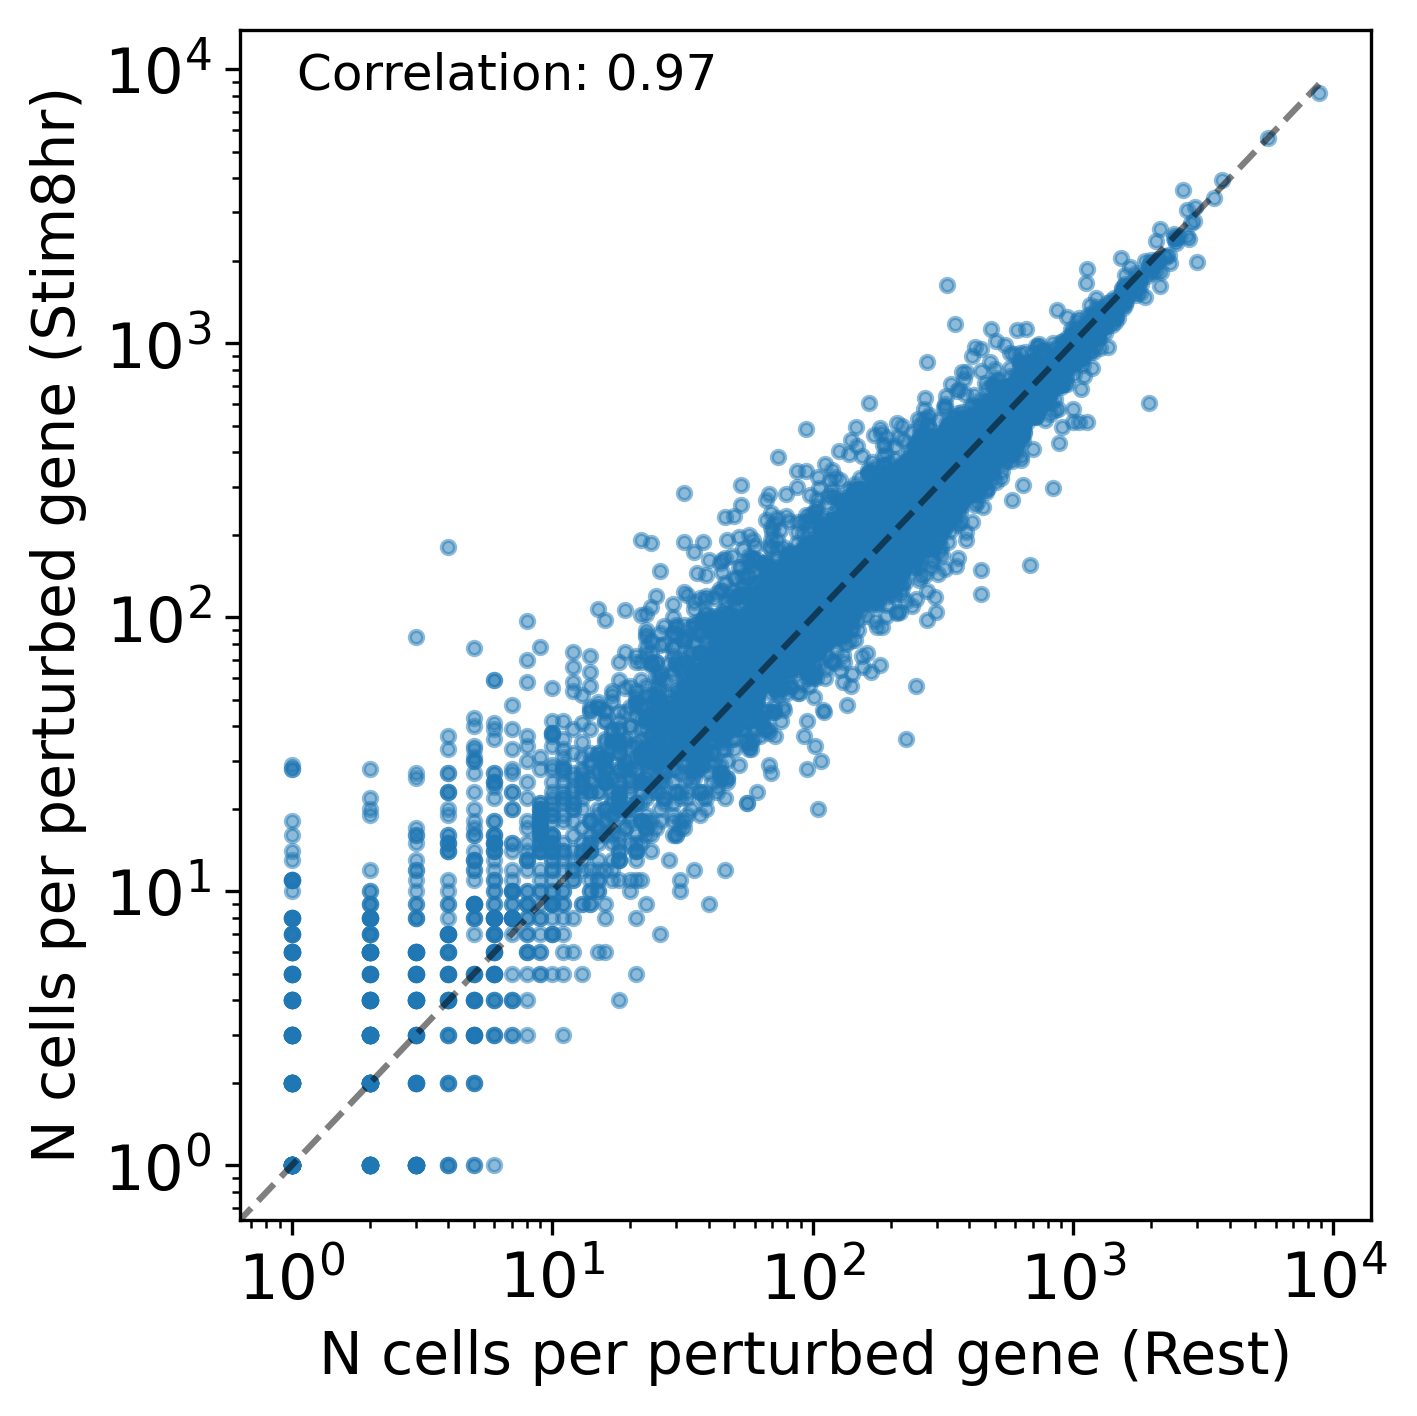

In [40]:
# Create a scatter plot comparing cell counts between conditions
plt.figure(figsize=(5, 5))
plt.scatter(all_genes_df[all_genes_df['culture_condition'] == 'Rest']['n_cells'],
           all_genes_df[all_genes_df['culture_condition'] == 'Stim8hr']['n_cells'],
           alpha=0.5, s=10)

# Add diagonal line
max_val = max(all_genes_df['n_cells'].max(), all_genes_df['n_cells'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

plt.xlabel('N cells per perturbed gene (Rest)', fontsize=14)
plt.ylabel('N cells per perturbed gene (Stim8hr)', fontsize=14)

# Add correlation coefficient
corr = all_genes_df.pivot(columns='culture_condition', 
                         index='perturbed_gene_name', 
                         values='n_cells').corr().iloc[0,1]
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
         transform=plt.gca().transAxes, fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

## Check sgRNA assignments

In [41]:
from tqdm.notebook import tqdm

Processing Rest samples:   0%|          | 0/5 [00:00<?, ?it/s]

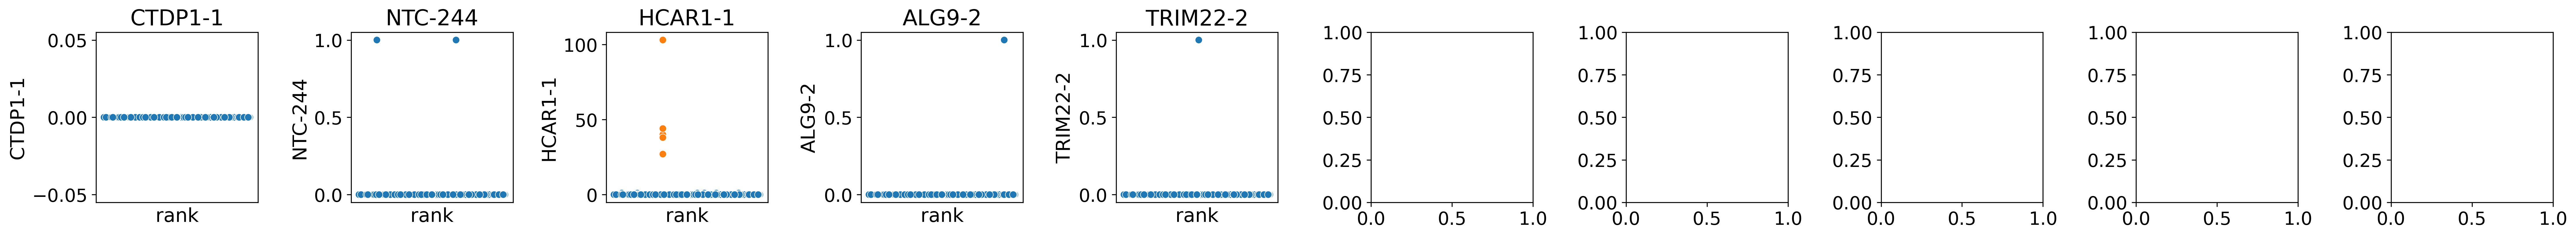

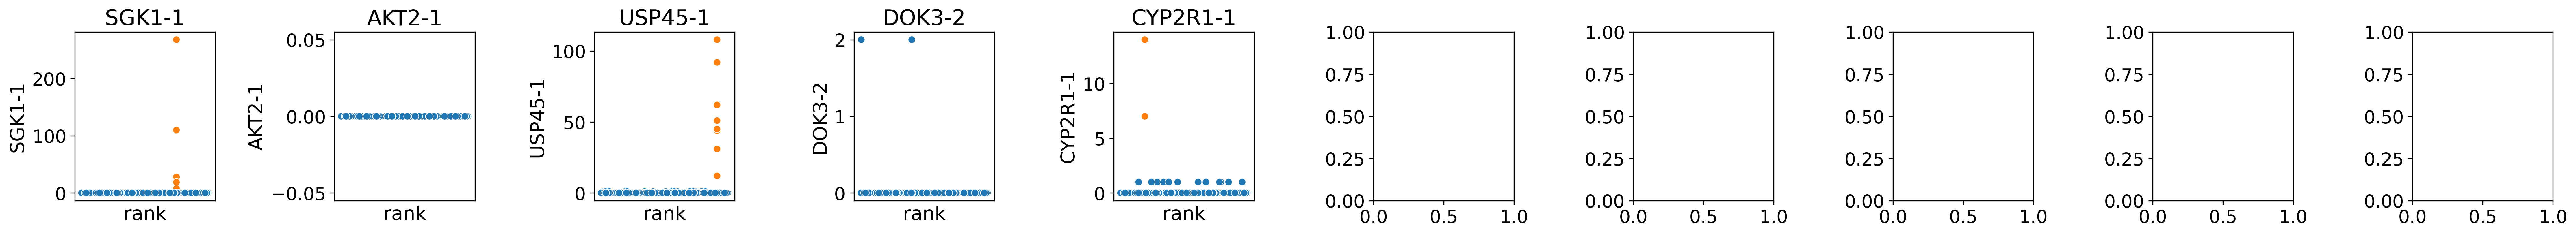

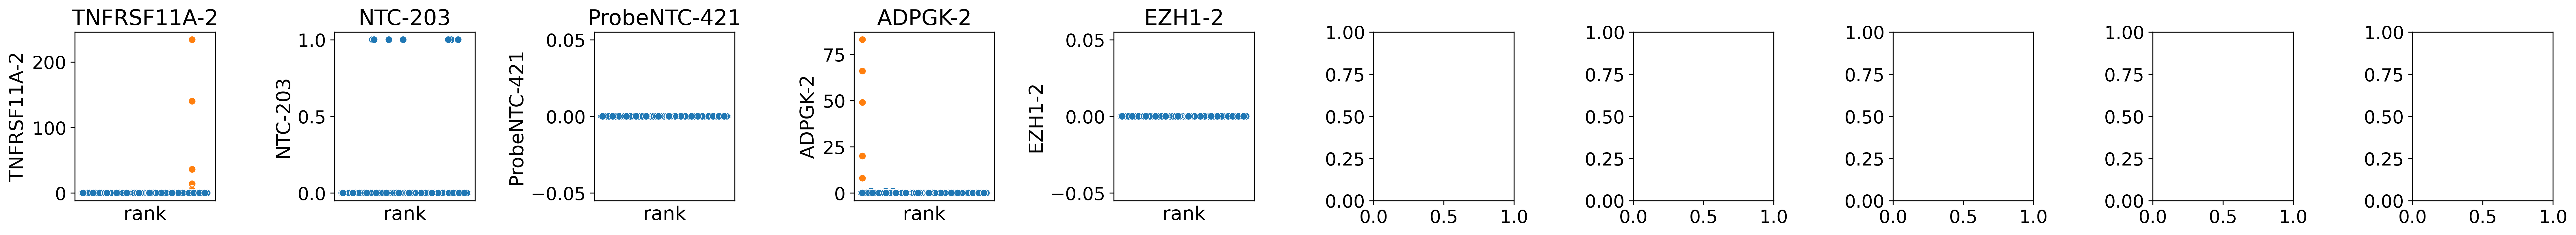

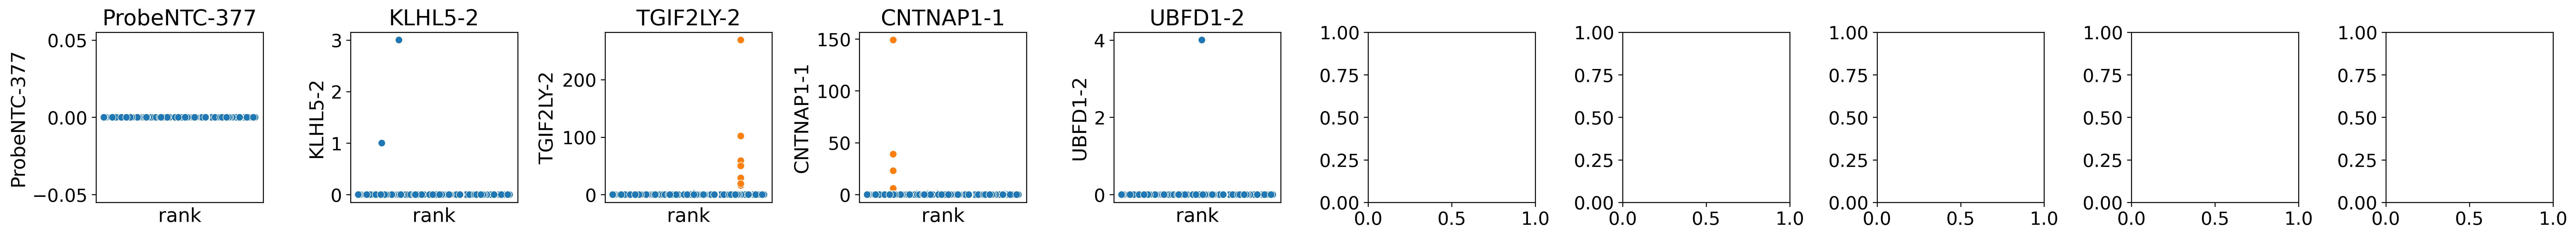

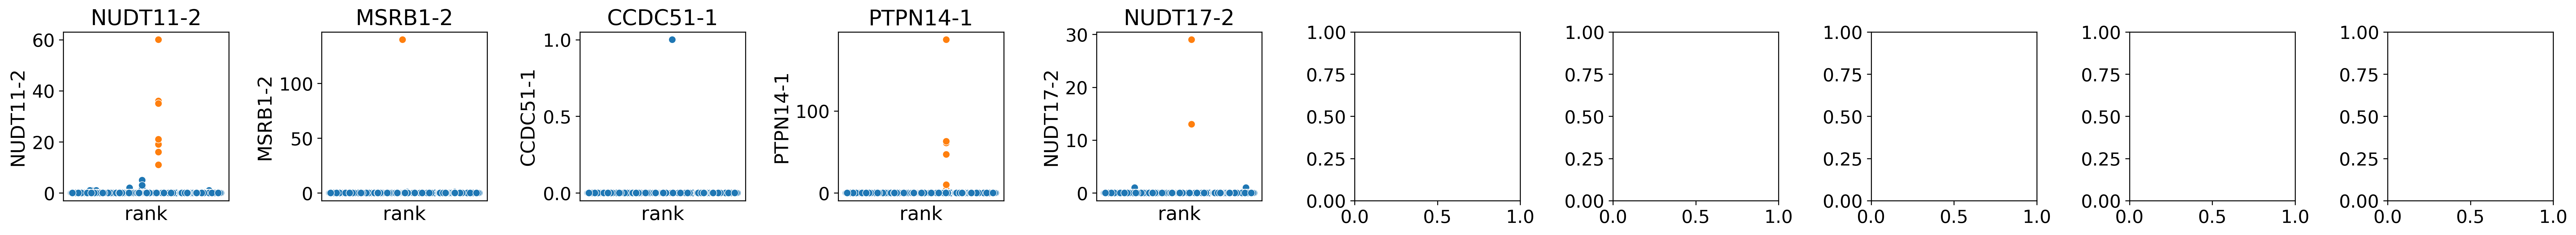

In [42]:
for sample_id in tqdm(np.random.choice(all_samples, 5), desc="Processing Rest samples"):
    # f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
    f = f'{datadir}/{sample_id}.sgRNA.h5ad'
    try:
        adata = ad.read_h5ad(f)
        # adata.X = adata.X.compute()
        # adata.obs = adata.obs.to_dataframe()
        # adata.var = adata.var.to_dataframe()
        assignment = sgrna_assignments2adata(adata, datadir, sgrna_library_metadata=sgrna_library_metadata, sample_id=sample_id)
        # Create figure with one row and 10 columns
        fig, axes = plt.subplots(1, 10, figsize=(30, 3))
        
        # Plot each gene in its own subplot
        for i, g in enumerate(np.random.choice(adata.var_names, 5)):
            check_df = sc.get.obs_df(adata[adata.obs.guide_id != 'multi_sgRNA'], ['guide_id', g])
            check_df['assigned_guide'] = check_df['guide_id'] == g
            check_df['rank'] = check_df.rank()['guide_id']
            
            sns.scatterplot(data=check_df, x='rank', y=g, hue='assigned_guide', ax=axes[i], legend=False)
            axes[i].set_xticks([])
            axes[i].set_title(g)
            
        plt.tight_layout()
        plt.show()
    except:
        continue

In [43]:
# for sample_id in tqdm(all_samples[0:10], desc="Processing samples"):
#     f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
#     # f = f'{datadir}/{sample_id}.sgRNA.h5ad'
#     try:
#         adata = ad.experimental.read_lazy(f)
#         # adata.X = adata.X.compute()
#         # adata.obs = adata.obs.to_dataframe()
#         # adata.var = adata.var.to_dataframe()

#         adata.X = adata.X.compute()
#         adata.obs = adata.obs.to_dataframe()
#         adata.var = adata.var.to_dataframe()
#         sc.pp.normalize_total(adata)
#         sc.pp.log1p(adata)
#         adata.var_names = adata.var['gene_name'].copy()

#         # Spot check knock-downs
#         expr_genes = adata.var_names[adata.var['mean_counts'] > 0.1]
#         seen_perturbs = adata.obs['perturbed_gene_name'].value_counts()[1:500].index.tolist()

#         gs = np.random.choice(np.intersect1d(expr_genes, seen_perturbs), 5).tolist()

#         sc.pl.violin(
#             adata[adata.obs['perturbed_gene_name'].isin(list(gs) + ['NTC'])],
#             gs, groupby='perturbed_gene_name')
#     except FileNotFoundError:
#         continue